# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [513]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython.display import HTML

from sklearn import datasets
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

In [910]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_pred.shape[0]

def model_accuracy(model, random_state=16):
    X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]], random_state=random_state)
    X_moons, y_moons = make_moons(400, noise=0.075, random_state=random_state)

    print("Blobs accuracy: ", accuracy(y, model(iterations=10).fit(X, y).predict(X)))
    print("Moons accuracy: ", accuracy(y_moons, model(iterations=10).fit(X_moons, y_moons).predict(X_moons)))

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [923]:
# for the future: https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975
class Perceptron:
    def __init__(self, iterations: int = 100, alpha=0.5):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.
        """
        self.iterations = iterations
        self.alpha = alpha
        self.w = None
        self.labels = None
    
    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _predict(self, X):
        return (X @ self.w > 0).astype(np.int).ravel()
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> "Perceptron":
        """
        Обучает простой перцептрон. 
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        self.labels, y = np.unique(y, return_inverse=True)
        assert self.labels.shape[0] == 2
        
        self.w = np.zeros((X.shape[1] + 1, 1))
        X = self._add_intercept(X)
        
        for epoch in range(self.iterations):            
            # кажется, что правильнее для каждой новой точки делать предсказание и менять веса, а не предсказывать заранее
            # но результат так получается хуже (по точности), тем не менее иногда он может делать слишком сильный сдвиг за эпоху
            # если изначально ошибся на многих точках (как в moons) - это решается меньшим learning rate + батчи
            # при инициализации весов далеко от выборки такой подход даже лучше, ибо сделает за одну эпоху больший сдвиг
            y_pred = self._predict(X) 
            for i in range(X.shape[0]):
                if y_pred[i] != y[i]:
                    self.w = self.w + self.alpha * (y[i] - y_pred[i]) * X[i].reshape(-1, 1)
        
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        if self.w is None or self.labels is None:
            raise AttributeError("Instance is not fitted yet.")
        pred = self._predict(self._add_intercept(X))
        
        return self.labels[pred]

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [922]:
model_accuracy(Perceptron, random_state=16)

Blobs accuracy:  0.9775
Moons accuracy:  0.87


In [28]:
# т.к. у нас простые данные, я решил, что нагляднее будет посмотреть на анимацию того, как перцептрон учится
# !pip install celluloid  # совсем маленький пакет
# !python animation.py

## Blobs

<img src="perceptron_bloobs.gif" width="480" align="center">

## Moons

<img src="perceptron_moons.gif" width="480" align="center">

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [924]:
class PerceptronBest:

    def __init__(self, iterations: int = 100, alpha=0.5):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.
        """
        self.iterations = iterations
        self.alpha = alpha
        self.w = None
        self.labels = None
            
    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _predict(self, X):
        return (X @ self.w > 0).astype(np.int).ravel()
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> "PerceptronBest":
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона, 
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса, 
        при которых значение accuracy было наибольшим.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        self.labels, y = np.unique(y, return_inverse=True)
        assert self.labels.shape[0] == 2
        
        self.w = np.zeros((X.shape[1] + 1, 1))
        X = self._add_intercept(X)
        
        best_w, best_score = None, -np.inf
        for epoch in range(self.iterations):
            y_pred = self._predict(X)
            
            for i in range(X.shape[0]):
                if y_pred[i] != y[i]:
                    update_sign = y[i] - y_pred[i]
                    
                    self.w = self.w + self.alpha * update_sign * X[i].reshape(-1, 1)
                    
            score = accuracy(y, self._predict(X))
            if score > best_score:
                best_score, best_w = score, np.copy(self.w)

        self.w = best_w
        
        return self
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        if self.w is None or self.labels is None:
            raise AttributeError("Instance is not fitted yet.")
            
        pred = self._predict(self._add_intercept(X))
            
        return self.labels[pred]

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

In [926]:
model_accuracy(PerceptronBest, random_state=16)

Blobs accuracy:  0.9775
Moons accuracy:  0.875


### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [685]:
def transform_images(images: np.ndarray) -> np.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.
        
    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    n_images, image_height, image_witdth = images.shape
    X = np.zeros((images.shape[0], 2))
    
    h_sym = np.abs(images - images[:, ::-1]).mean(axis=(1, 2))
    w_sym = np.abs(images - images[:, :, ::-1]).mean(axis=(1, 2))
    
    X[:, 0] = h_sym
    X[:, 1] = w_sym
    
    return X

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

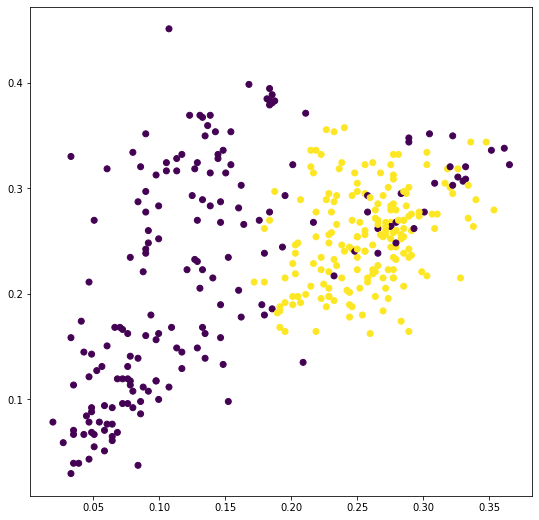

In [686]:
X, y = get_digits()
plt.figure(figsize=(9, 9))
plt.scatter(X[:, 0], X[:, 1], c=y);

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [687]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

Accuracy: 0.7808219178082192


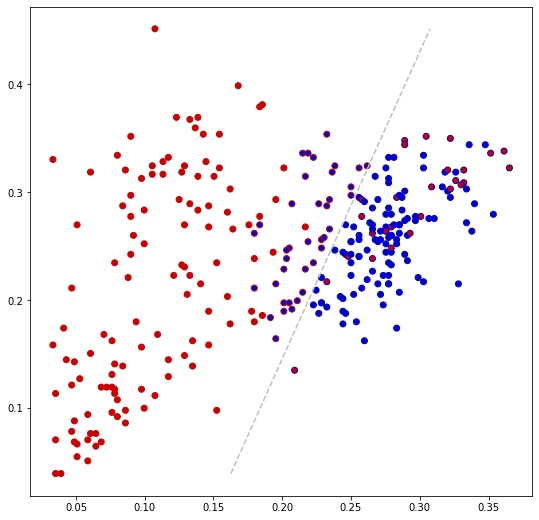

In [688]:
c = Perceptron(iterations=1000)
c.fit(X_train, y_train)

visualize(X_train, y_train, c.predict(X_train), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

Accuracy: 0.958904109589041


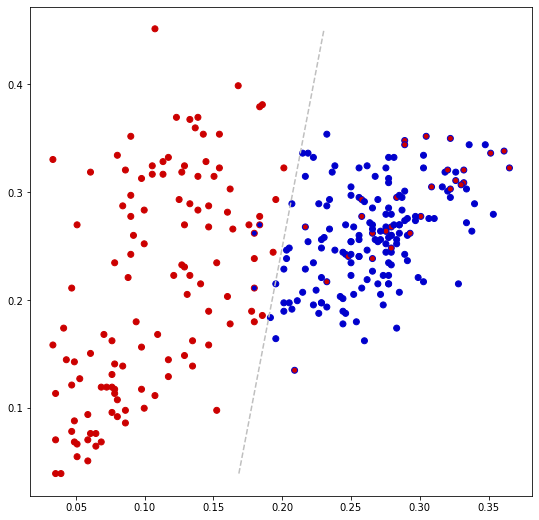

In [689]:
c = PerceptronBest(iterations=1000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [692]:
accs = []
for y0, y1 in tqdm([(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]):
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=500)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))


Mean accuracy: 0.7025330317776778


In [697]:
accs = []
for y0, y1 in tqdm([(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]):
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=1000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))


Mean accuracy: 0.7404969475231228
